# Dynamic Word Embeddings

- by Jacob Eisenstein, May 2019
- modified by Hang Jiang, Sept. 2019

The previous notebook tracked how words were used by different groups over time. 
Now we'll explore how words change meaning over time, using dynamic word embeddings. The specific goals are:

- Identify near-neighbors of words at various periods in time.
- Align word embeddings over time using by solving an orthogonal Procrustes problem.
- Rank words by semantic change from age 0 to age 3, using "first-order" (embedding-based) and "second-order" (neighbor-based) techniques.

## Data acquisition

Because training dynamic word embeddings is time-consuming, we'll use pretrained embeddings from [Hamilton et al](https://github.com/williamleif/histwords). As before, these embeddings are available in the [bitbucket repository](https://bitbucket.org/jacobeisenstein/language-change-tutorial-data/src/master/embeddings-over-time.tgz). 

1. If you have not already cloned it, please run:

```
git clone https://bitbucket.org/jacobeisenstein/language-change-tutorial-data.git

```
2. Then link or move the directory into `../data`,
```
cd data; ln -s ../language-change-tutorial-data/embeddings-over-time
```


In [2]:
import os
from glob import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook as tqdm # convenient progressbar

## Data loading

In [3]:
from typing import List, Dict, Tuple, Sequence
base_dir = os.path.join('/Users/hang/Desktop/2019-fall/change/','childes_data','embeddings-over-time') # make sure you expand the tar file in ../data
dicts = pickle.load(open(os.path.join(base_dir,'embeddings-over-time-vocabs-ep3.pickle'),'rb'))

vocs: Dict[int, List] = {k: list(v.keys()) for k, v in dicts.items()}
years: List[int] = list(vocs.keys()) # 0, 1
# print(vocs)
vecs: Dict[int, List] = dict()
    
# 0 ./childes_data/adult_utterances_age_corpus_48_60 .csv
# 1 ./childes_data/adult_utterances_age_corpus_0_12.csv
# 2 ./childes_data/adult_utterances_age_corpus_36_48 .csv
# 3 ./childes_data/adult_utterances_age_corpus _12_24 .csv

for year, d in dicts.items():
    year_vectors = np.array([list(d.values())]).reshape(-1, 100)
    print(year_vectors.shape)
    vecs[year] = year_vectors / np.linalg.norm(year_vectors, axis=-1)[:, np.newaxis]
#     for w in vecs[year] /= norms
    print(vecs[year])

(1106, 100)
[[ 0.09955715 -0.01613173  0.01863669 ... -0.24227965 -0.04198108
   0.09792186]
 [ 0.00414176 -0.11482116 -0.10943656 ...  0.12671569  0.12409339
  -0.0757904 ]
 [ 0.14456597  0.06232343 -0.06673271 ... -0.17482287  0.01226527
   0.04235525]
 ...
 [ 0.12435605  0.04135474 -0.08706639 ... -0.15162618 -0.00971869
  -0.02547862]
 [ 0.11133149  0.0208369  -0.0716225  ... -0.20013537 -0.00942668
   0.03248657]
 [ 0.02439606 -0.00722408 -0.00411762 ... -0.14964803 -0.02218689
   0.02327476]]
(4324, 100)
[[-0.01634657  0.00807319  0.07357773 ...  0.1207446  -0.11049235
   0.02366184]
 [-0.04880011 -0.09047389  0.07564899 ...  0.07464469 -0.03567304
  -0.11710779]
 [ 0.04724394 -0.03434989  0.01360201 ...  0.11452807  0.08729791
   0.05257946]
 ...
 [-0.0593846   0.12744443 -0.16291556 ...  0.16967757  0.0861298
   0.1364089 ]
 [ 0.14035253 -0.05965653  0.14019345 ... -0.15180631  0.02578908
   0.15354733]
 [-0.00157491 -0.10671422  0.07831632 ... -0.19469295 -0.08446645
   0.2486

In [4]:
(vecs[1]**2).sum(1)

array([1.0000001 , 0.99999994, 1.0000001 , ..., 0.99999994, 1.0000001 ,
       0.9999998 ], dtype=float32)

Vectors are initialized to have a Euclidean norm of $1$. There are different number of words per year, listed in `vocs[year]`.

# Near neighbors

Let's start by computing some near neighbors. In general, this is done by computing cosine similarity between word vectors,
\begin{equation}
s(\vec{x},\vec{y}) = \frac{\vec{x} \cdot \vec{y}}{||\vec{x}|| \times || \vec{y} ||}.
\end{equation}

However, because these embeddings have a guaranteed norm of 1, the denominator can be ignored, so we need only consider the dot product.

In [5]:
def neighbors(query : str,
              embs: np.ndarray,
              vocab: list,
              K : int = 3) -> list:
    sims = np.dot(embs[vocab.index(query),],embs.T)
    output = []
    for sim_idx in sims.argsort()[::-1][1:(1+K)]:
        if sims[sim_idx] > 0:
            output.append(vocab[sim_idx])
    return output

In [6]:
# a convenience function to compute the nearest neighbors per year
def neighbors_per_year(query: str, K=5) -> dict:
    nns = dict()
    for year, embs in vecs.items():
        nns[year] = neighbors(query, embs, vocs[year], K=K)
    return nns

## Examples

In [7]:
for year, nn_list in neighbors_per_year('daddy').items():
    print(year, nn_list)

0 ['everybody', 'hurry', 'Mickey_Mouse', 'bud', 'laundry']
1 ['Daddy', 'dad', 'mommy', 'Mommy', 'ma']
2 ['mommy', 'mum', 'Daddy', 'dad', 'mom']
3 ['mommy', 'Daddy', 'ma', 'mum', 'dad']


In [8]:
for year, nn_list in neighbors_per_year('dog').items():
    print(year, nn_list)

0 ['our', 'frog', 'mamama', 'short', 'rest']
1 ['puppy', 'fox', 'kitty', 'clown', 'mouse']
2 ['kitty', 'cow', 'cat', 'horse', 'sheep']
3 ['cat', 'kitty', 'cow', 'horse', 'sheep']


In [9]:
for year, nn_list in neighbors_per_year('sun').items():
    print(year, nn_list)

0 ['by', 'rain', 'knee', 'knock', 'yourself']
1 ['sky', 'tunnel', 'light', 'river', 'plane']
2 ['warm', 'cloud', 'shine', 'air', 'wind']
3 ['warm', 'pop', 'egg', 'Sunday', 'tiny']


### Exercise 

Try to find an example with as many similar neighbors as possible in age 1 and age 3; try to find another example as few similar neighbors as possible.

# Linking embedding over time

The first task is simple to align words across vocabularies. We will do this by building a sparse permutation matrix.

In [10]:
import scipy.sparse as sparse

In [11]:
def build_alignment(year1 : int, year2 : int) -> sparse.csr_matrix:
    # given two years (keys into vecs and vocs)
    # compute a sparse matrix M representing the permutation of word indices from the year1 vecs to the year2 vecs  
    # then the rows of v1 will be aligned with the rows of M v2 
    
    all_var1 = vecs[year1].var(1)
    all_var2 = vecs[year2].var(1)

    rows = []
    cols = []

    ivoc2 = {j:i for i,j in enumerate(vocs[year2])}

    for widx1,word in enumerate(vocs[year1]):
        if all_var1[widx1] != 0 and word in vocs[year2]:
            widx2 = ivoc2[word]
            if all_var2[widx2] != 0:
                rows.append(widx1)
                cols.append(widx2)

    align = sparse.csr_matrix(([1]*len(rows),(rows,cols)),shape=[len(vocs[year1]),len(vocs[year2])])
    return align

In [12]:
# for the rest of the notebook, we'll focus on the contrast between age 1 and age 3
year1 = 1
year2 = 3

In [13]:
align = build_alignment(year2, year1)

In [14]:
align

<5386x4324 sparse matrix of type '<class 'numpy.int64'>'
	with 3130 stored elements in Compressed Sparse Row format>

In [15]:
vecs_aligned = align.dot(vecs[year1])

To validate, let's check that words in `vecs_aligned` have roughly the same near-neighbors as in `vecs[year2]`.

In [16]:
for query in ['car','bottle','dog','love']:
    print(query)
    print(year1, neighbors(query, vecs_aligned, vocs[year2], K=7))
    print(year2, neighbors(query, vecs[year2], vocs[year2], K=7),'\n')

car
1 ['truck', 'train', 'tractor', 'garage', 'airplane', 'stroll', 'wagon']
3 ['truck', 'boat', 'train', 'garage', 'bus', 'ambulance', 'plane'] 

bottle
1 ['milk', 'cup', 'spoon', 'juice', 'pitcher', 'cookie', 'drink']
3 ['glass', 'stone', 'basket', 'pot', 'jar', 'hose', 'sink'] 

dog
1 ['puppy', 'fox', 'kitty', 'clown', 'mouse', 'lion', 'goose']
3 ['cat', 'kitty', 'cow', 'horse', 'sheep', 'monkey', 'wolf'] 

love
1 ['ask', 'thirst', 'hug', 'give', 'aunt', 'feed', 'offer']
3 ['hate', 'enjoy', 'honest', 'bet', 'wish', 'understand', 'thirst'] 



## Procrustes

$\newcommand{\transpose}[1]{#1^{\top}}$

The orthogonal Procrustes problem for matrices $A$ and $B$ is to find an orthogonal projection matrix $\Omega$ that minimizes the norm of the difference between $\Omega A$ and $B$:

\begin{equation}
\min_{\Omega} ||\Omega A - B ||_F,
\end{equation}
s.t. $\transpose{\Omega} \Omega = \mathbb{I}$, where $A, B \in \mathbb{R}^{K \times V}$ are matrices of $K$-dimensional embeddings, and $\Omega$ is therefore an orthonormal $K \times K$ projection matrix. The norm $||M||_F = \left(\sum_i \sum_j m_{i,j}^2\right)^{1/2}$. 

The solution to the orthogonal Procrustes problem is obtained by performing singular value decomposition on the product,

\begin{align}
U \Sigma \transpose{V} = &{} \text{SVD}(B\transpose{A})\\
\Omega = &{} U \transpose{V}.
\end{align}


## Procrustes

In [17]:
def procrustes(A, B):
    U, _, Vt = np.linalg.svd(B.dot(A.T))
    return U.dot(Vt)

### Synthetic data

In [18]:
# randomly generate an orthogonal projection
P1,_,_ = np.linalg.svd(np.random.randn(100,30))
A = np.random.randn(100,1000)
B = P1.dot(A) + 0.1 * np.random.randn(100,1000)

print(f'Norm without projection:\t{np.linalg.norm(B - A):0.3f}')
print(f'Norm with projection:\t{np.linalg.norm(B - procrustes(A,B).dot(A)):0.3f}')

Norm without projection:	316.576
Norm with projection:	30.950


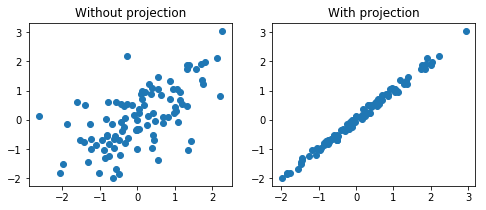

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[8,3])
ax1.scatter(A[:,45],B[:,45])
ax1.set_title("Without projection")
ax2.scatter(procrustes(A,B).dot(A[:,45]),B[:,45]);
ax2.set_title('With projection');

**Exercise**: evaluate the projection quality while varying the amount of noise in $B$.

## Application to word vectors

Let $A \in \mathbb{R}^{K \times V}$ be the matrix of aligned word vectors, with words on the columns, and let $B \in \mathbb{R}^{K \times V}$ be an analogous matrix of word vectors at an alternative time. Then we solve the orthogonal Procrustes problem to obtain the projection $\Omega$.

In [20]:
Omega = procrustes(vecs_aligned.T, vecs[year2].T)
vecs_projected = Omega.dot(vecs_aligned.T).T

In [21]:
length_of_vocab = min(vecs[year1].shape[0], vecs[year2].shape[0])
print(length_of_vocab)

4324


In [22]:
print('pre-alignment: ',np.linalg.norm(vecs[year2][:length_of_vocab] - vecs[year1]))
print('pre-projection: ',np.linalg.norm(vecs[year2] - vecs_aligned))
print('after projection: ',np.linalg.norm(vecs[year2] - vecs_projected))

pre-alignment:  80.9609
pre-projection:  80.6369473082392
after projection:  66.70061763012454


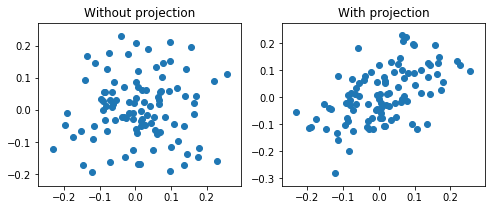

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[8,3])

query = 'fish'
vec2_no_project = vecs_aligned[vocs[year2].index(query),]
vec2_projected = vecs_projected[vocs[year2].index(query),]
vec1_query = vecs[year2][vocs[year2].index(query),]

ax1.scatter(vec1_query, vec2_no_project)
ax1.set_title("Without projection")

ax2.scatter(vec1_query, vec2_projected)
ax2.set_title('With projection');

After projection the alignment is closer, but still far from perfect.

## Measuring semantic change by embedding norms

After projection, we can search for words with large changes in meaning by evaluating the "cosine distance" between the projected embedding in $t_1$ and the embedding in $t_2$.

In [24]:
def compute_cos_dist(vec1 : np.array, vec2 : np.array) -> np.array:    
    numerator = (vec1 * vec2).sum(1)
    denominator = np.sqrt((vec1**2).sum(1)) * np.sqrt((vec2**2).sum(1))
    cos_dist = 1 - numerator / (1e-5 + denominator)

    # eliminate words that are zeroed out
    return cos_dist * (vec1.var(1) > 0) * (vec2.var(1) > 0)

In [25]:
cos_dist = compute_cos_dist(vecs[year2], vecs_projected)

### Top words by global metric

Now let's print the words with the biggest changes from Age 1 to Age 3. 

The embeddings for rare words are a little weird, so let's focus on the 10K most frequent.

In [26]:
thresh = 10000
for idx in cos_dist[:thresh].argsort()[::-1][:20]:
    word = vocs[year2][idx]
    print(f'{word}\t(ranks={idx},{vocs[year1].index(word)})\tdist={cos_dist[idx]:.2f}')
    print(f'age {year2} neighbors: {neighbors(word, vecs_projected, vocs[year2], K=7)}')
    print(f'age {year2} neighbors: {neighbors(word, vecs[year2], vocs[year2], K=7)}\n')

umhum	(ranks=1370,3984)	dist=1.11
age 3 neighbors: ['please', 'paper', 'floor', 'laundry', 'puzzle', 'bring', 'honey']
age 3 neighbors: ['Uncle_Stuart', 'dumbo', 'Mary_Poppins', 'howdy', 'hiya', 'Seymore', 'giddyup']

mmmm	(ranks=4661,2280)	dist=1.09
age 3 neighbors: ['grip', 'hurray', 'woah', 'Shawn', 'shot', 'koolaid', 'Dino']
age 3 neighbors: ['blue', 'string', 'saucer', 'space', 'tree', 'helmet', 'board']

whoopsie	(ranks=4585,1305)	dist=1.03
age 3 neighbors: ['heehee', 'echo', 'N', 'patter', 'gulp', 'wa', 'du']
age 3 neighbors: ['anyway', 'change', 'problem', 'ah', 'voice', 'throat', 'stop']

Cathy	(ranks=384,3154)	dist=0.96
age 3 neighbors: ['Mikey', 'Yvonne', 'loft', 'chowder', 'cheers', 'brilliant', 'eee']
age 3 neighbors: ['Sylvia', 'och', 'you_know', 'Gillian', 'Mummy', 'I_mean', 'God']

yah	(ranks=5315,2089)	dist=0.93
age 3 neighbors: ['Cookie', 'pedal', 'Huey', 'Wendy', 'N', 'du', 'wa']
age 3 neighbors: ['Eric', 'downstairs', 'had_to', 'slow', 'shot', 'ought_to', 'Peter']



Better! A few preprocessing effects ("00" and "addison"), but most of these changes are interpretable as emerging word senses ("aids", "peer", "approaches", "facility", "film", and "resource").

## Measuring semantic change by near neighbors

A concern with comparing word embeddings directly is that different parts of the embedding space may have different densities, so that cosine distances are not comparable across the entire space. 

To address this problem, [Hamilton et al (2016b)](https://nlp.stanford.edu/pubs/hamilton2016cultural.pdf) propose a "local" technique:

1. For word $w$ at time $t$, identify $K$-nearest neighbors $\mathcal{N}_t(w)$
2. Compute the vector of cosine similarities to the union of these neighbors,

\begin{align}
\vec{s}_t(w) = &{} [\cos(x_{t}(w), x_t(w')) : w' \in \mathcal{N}_t(w) \cup \mathcal{N}_{t'}(w)]\\
\vec{s}_{t'}(w) = &{} [\cos(x_{t'}(w), x_{t'}(w')) : w' \in \mathcal{N}_t(w) \cup \mathcal{N}_{t'}(w)]\\
\end{align}

3. Compute the cosine distance between these two vectors, $D_{t,t'}(w) = 1 - \cos(\vec{s}_t(w), \vec{s}_{t'}(w))$.

Intuitively, if a word acquires a large number of new neighbors at $t'$, and these neighbors had very different embeddings from $x_t(w)$ at time $t$, then the distance will be large; if the neighbors and their similarities to $w$ are roughly the same at $t$ and $t'$, then the distance will be small. Let's compute it.

#### Example

In [27]:
query = 'like'
nn_old = neighbors(query, vecs[year1], vocs[year1], K=5)
nn_new = neighbors(query, vecs[year2], vocs[year2], K=5)
print(nn_old)
print(nn_new)

['want', 'rather', 'pretend', 'enjoy', 'fun']
['fun', 'want', 'familiar', 'love', 'prefer']


Now we'll construct a set of neighbors that combines these lists, omitting words that are out-of-vocabulary in either dataset.

In [28]:
neighbor_set = [word for word in set(nn_old).union(set(nn_new)) 
                if (word in vocs[year1])
                and (word in vocs[year2])
                and (vecs[year1][vocs[year1].index(word)].var() > 0)
                and (vecs[year2][vocs[year2].index(word)].var() > 0)]
print(neighbor_set)

['want', 'rather', 'pretend', 'familiar', 'enjoy', 'fun', 'prefer', 'love']


For each of these words, we will compute the cosine similarity to the query, in each dataset. 

Because the vectors are guaranteed to have a unit norm, the cosine similarity is identical to the dot product.

In [29]:
def get_neighbor_sims(query : str, neighbor_set : set, vec : np.ndarray, voc : list) -> np.ndarray:
    v_self = vec[voc.index(query),]
    v_neighbors = vec[[voc.index(neighbor) for neighbor in neighbor_set],]
    return np.dot(v_neighbors, v_self)

In [30]:
sim_old = get_neighbor_sims(query,neighbor_set,vecs[year1],vocs[year1])
sim_new = get_neighbor_sims(query,neighbor_set,vecs[year2],vocs[year2])
print(sim_old)
print(sim_new)

[0.45704734 0.38829723 0.3705384  0.14188018 0.3598885  0.3541044
 0.23904556 0.30166852]
[0.42975855 0.2995243  0.12024475 0.40397727 0.24939671 0.49816003
 0.3883096  0.3935904 ]


Finally, we'll measure semantic shift by the average "distance" between these vectors of similarities. 

This is a "second order" view of semantic change, but we will call it the *local* change, because it is based only on the local neighborhood and not the global embedding space.

In [31]:
compute_cos_dist(sim_old.reshape(1,-1), sim_new.reshape(1,-1))[0] / len(neighbor_set)

0.012492753565311432

We'll now make this calculation for the entire dataset. By default, we'll just load the results, but you can recompute it from this data if you have a few minutes.

In [32]:
recompute_embedding_shifts = True
emb_shift_file = os.path.join('.','data','embedding-shifts.csv')

In [33]:
if recompute_embedding_shifts:
    # this may take 5-10 minutes to execute
    neighbor_shift = dict()

    num_neighbors = 25

    for word in tqdm(vocs[year2]):
        if word in vocs[year1]:
            nn_old = neighbors(word, vecs[year1], vocs[year1], K=num_neighbors)
            nn_new = neighbors(word, vecs[year2], vocs[year2], K=num_neighbors)

            neighbor_set = [word for word in set(nn_old).union(set(nn_new)) 
                            if (word in vocs[year1])
                            and (word in vocs[year2])
                            and (vecs[year1][vocs[year1].index(word)].var() > 0)
                            and (vecs[year2][vocs[year2].index(word)].var() > 0)]
        
            s1 = get_neighbor_sims(word, neighbor_set, vecs[year1], vocs[year1])
            s2 = get_neighbor_sims(word, neighbor_set, vecs[year2], vocs[year2])

            dL = compute_cos_dist(s1.reshape(1,-1),s2.reshape(1,-1))[0] / len(neighbor_set)
    
            neighbor_shift[word] = dL
    df_emb_shift = pd.DataFrame({'local':list(neighbor_shift.values()),
                                 'global':[cos_dist[vocs[year2].index(word)] for word in neighbor_shift.keys()]},
                                index=list(neighbor_shift.keys()))
    df_emb_shift.to_csv(emb_shift_file)
else:
    df_emb_shift = pd.read_csv(emb_shift_file,index_col=0)

Let's put the results into a dataframe.

In [34]:
print(df_emb_shift.sort_values('local',ascending=False).head(20))

              local    global
umhum      0.032209  1.109406
eee        0.023869  0.153202
whoopsie   0.021422  1.034340
Sally      0.019995  0.903671
afterward  0.019183  0.881559
mmmm       0.019178  1.090210
loft       0.018723  0.857577
come_on    0.016196  0.681591
Bobby      0.016109  0.879569
constant   0.015989  0.759752
patter     0.015370  0.389428
Cathy      0.015095  0.955261
Chris      0.014366  0.678526
sleigh     0.014239  0.554668
yah        0.014133  0.928040
hoppity    0.013977  0.427039
wave       0.013775  0.699080
Nomi       0.013278  0.797238
Cape       0.013252  0.592877
in_case    0.013147  0.553306


### Top words by "local" metric

In [35]:
for word in df_emb_shift.sort_values('local',ascending=False).head(20).index:
    print(word)
    print(f'Age {year1} neighbors: {neighbors(word, vecs[year1][:thresh], vocs[year1], K=7)}')
    print(f'Age {year2} neighbors: {neighbors(word, vecs[year2][:thresh], vocs[year2], K=7)}')
    print()

umhum
Age 1 neighbors: ['please', 'paper', 'floor', 'laundry', 'puzzle', 'bring', 'honey']
Age 3 neighbors: ['Uncle_Stuart', 'dumbo', 'Mary_Poppins', 'howdy', 'hiya', 'Seymore', 'giddyup']

eee
Age 1 neighbors: ['ticktock', 'ribbet', 'eggies', 'bady', 'Dawn', 'delivery', 'who_who']
Age 3 neighbors: ['magician', 'Sneezy', 'Louisa', 'Dylan', 'G_I_Joe', 'Castle', 'Sleepy']

whoopsie
Age 1 neighbors: ['oopsie', 'dink', 'buba', 'heehee', 'kalik', 'echo', 'haup']
Age 3 neighbors: ['anyway', 'change', 'problem', 'ah', 'voice', 'throat', 'stop']

Sally
Age 1 neighbors: ['Kalie', 'Chi', 'Violet', 'Megan', 'Mama', 'Alex', 'Bea']
Age 3 neighbors: ['Huey', 'Donald', 'scritch', 'north', 'boom', 'Duck', 'highway']

afterward
Age 1 neighbors: ['shut', 'peel', 'smack', 'wait', 'wind', 'pop', 'shout']
Age 3 neighbors: ['bong', 'noone', 'Fish', 'Sabato', 'Stephan', 'Allison', 'ksh']

mmmm
Age 1 neighbors: ['grip', 'hurray', 'woah', 'Humm_the_hamster', 'porpoise', 'Shawn', 'eeat']
Age 3 neighbors: ['blue

Pretty similar, but avoids a few of the false positives in `global`, such as "00", while weirdly including "the" as the top word.

## Extensions

- Try a number of different neighborhood sizes, and test how it affects the ranking of words. Is the "local" method sensitive to this parameter?
- Hamilton et al show that more common words tend to change more slowly. Can you replicate this finding using this data?
- Using the other datafiles, try to determine the pace of change over time; do words shift their meanings more in the late 20th century?
